In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import pandas as pd
from colorama import Fore
import pickle as pkl
import data, viz
from style import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all models

In [1]:
def load_results(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        metrics = {k: d['cv'][k] for k in d['cv'].keys() if not 'curve' in k}
        out = {k: np.mean(metrics[k]) for k in metrics}
        out.update({k + '_std': np.std(metrics[k]) for k in metrics})
        out['model_type'] = fname.replace('.pkl', '') #d['model_type']
        
        imp_mat = np.array(d['imps']['imps'])
        imp_mu = imp_mat.mean(axis=0)
        imp_sd = imp_mat.std(axis=0)
        
        feat_names = d['feat_names']
        out.update({feat_names[i] + '_f': imp_mu[i] for i in range(len(feat_names))})
        out.update({feat_names[i]+'_std_f': imp_sd[i] for i in range(len(feat_names))})
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1, sort=False).T.infer_objects()
    r = r.reindex(sorted(r.columns, reverse=True), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r
out_dir = 'results/outcome=iai_intervention'
results = load_results(out_dir)

NameError: name 'pkl' is not defined

**look at prediction metrics**

In [ ]:
# prev rule: sensitivity 0.97, specificity 0.425
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
# r = r.sort_values(by=['balanced_accuracy'], ascending=False)
r = r.sort_values(by=['sensitivity', 'specificity'], ascending=False)

# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap

r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

**look at feat importances**

In [ ]:
r = results
print(r.keys())
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r.sort_values('balanced_accuracy', ascending=False)
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
# r = r[r.index.str.contains('35')]
# r = r[r.index.str.contains('11')]
# r = r.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})

r = r[r.index.str.contains('20')]
r = r[r.index.str.contains('logistic')]
r = r[[k for k in r if not 'std' in k]]


def rank(r):
    '''Rank feature importances appropriately
    '''
    r = r.abs()
    r = r.rank(axis=1, ascending=False, method='min')
    return r
# 
# r = rank(r)
r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank
idxs = r.index
r.insert(0, 'balanced_acc', results.loc[idxs]['balanced_accuracy'])
r = r.sort_values('balanced_acc', ascending=False)
subset = list(r.keys())
subset.remove('balanced_acc')
# r.to_html('table.html')
# r = r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1) #, subset=subset) # rows differently colored


r = r.transpose()
r = r.reindex(r["logistic_20_ros=1"].abs().sort_values(ascending=False).index) # sort by abs value
# r = r.sort_values(by='logistic_20_ros=1')
r = r.fillna(0).style.background_gradient(cmap=cm, axis=0) #, subset=subset) # rows differently colored
# r = background_gradient(r)
r

# analyze individual model

In [14]:
df = data.get_data()
outcome_def = 'iai_intervention'
idxs_test = df.cv_fold.isin([6])
X_test, Y_test = df[idxs_test], df[outcome_def][idxs_test]

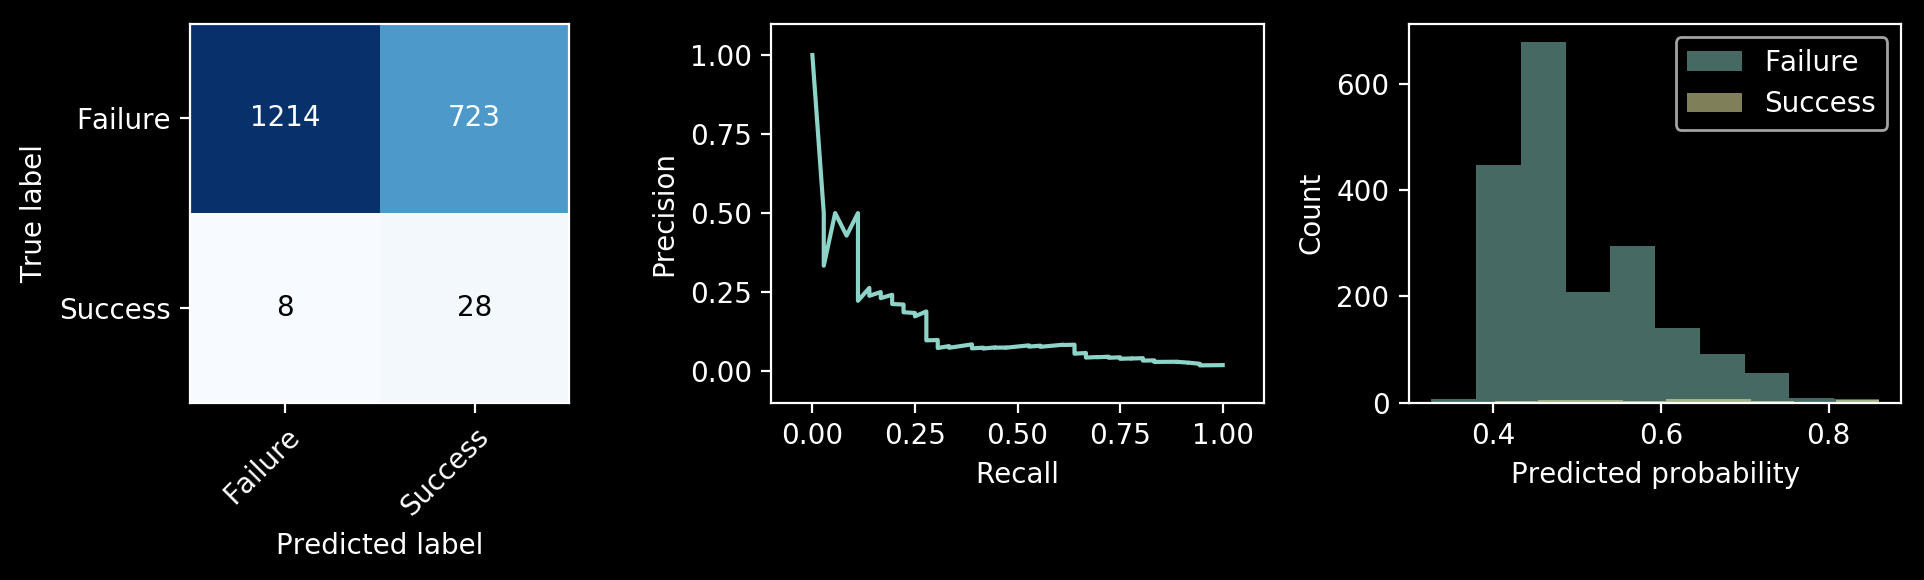

In [66]:
model_name = 'logistic_20_ros=5'
# results = pkl.load(open('results/classify_outcome=y_consec_sig/rf_ros_11.pkl', 'rb'))
results = pkl.load(open(f'results/outcome=iai_intervention/{model_name}.pkl', 'rb'))
preds, preds_proba = viz.visualize_individual_results(results, X_test, Y_test, print_results=False)

# misc analysis

In [ ]:
def count_common_feats(m_cv, model_type='tree'):
    if model_type == 'tree':
        feats_used = []
        for i in range(len(m_cv['estimator'])):
            m_fit = m_cv['estimator'][i]
            feats_used += list(ks[m_fit.feature_importances_ != 0])
    elif model_type == 'logistic':
        feats_used = []
        for i in range(len(m_cv['estimator'])):
            m_fit = m_cv['estimator'][i]
            num_feats = 5
            # get top num_feats features with biggest bsolute weights
            idxs = np.abs(m_fit.coef_).flatten().argsort()[-num_feats:][::-1]
            feats_used += list(ks[idxs])
    return sorted(dict(Counter(feats_used)).items(), key=lambda kv: kv[1], reverse=True)
        
count_common_feats(m_cv, model_type)

In [ ]:
# plot a tree
m_fit = m_cv['estimator'][0]
plt.figure(dpi=300)
plot_tree(m_fit, feature_names=ks)
plt.show()